# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
!rm -rf assignment1
!wget http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
!unzip spring1718_assignment1.zip
!rm spring1718_assignment1.zip
!cd ./assignment1 && ls

--2018-12-17 08:17:58--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.110.153, 185.199.109.153, 185.199.108.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.110.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.03s   

2018-12-17 08:17:58 (2.44 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]

Archive:  spring1718_assignment1.zip
   creating: assignment1/
 extracting: assignment1/.gitignore  
   creating: assignment1/.ipynb_checkpoints/
  inflating: assignment1/.ipynb_checkpoints/features-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/knn-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/softmax-checkpoint.ipynb  
  inflating: assignment1/.ipynb_checkpoints/svm-checkpoint.ipynb  
  inf

In [2]:
!cd assignment1/cs231n/datasets && bash get_datasets.sh && ls

--2018-12-17 08:18:06--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   696KB/s    in 3m 51s  

2018-12-17 08:21:57 (721 KB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
cifar-10-batches-py  get_datasets.sh


In [3]:
cd assignment1

/content/assignment1


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [0]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [0]:
from __future__ import print_function
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  # initialize some values
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero
  
  num_train = X.shape[0]
  delta = 1.0
  
  # compute the loss
  scores = np.dot(X, W)
  
  mask = np.ones_like(scores)
  mask[range(num_train),y] = 0
  correct_class = scores[range(num_train), y]
  losses = np.maximum(0, (mask * (scores - correct_class[:, np.newaxis] + delta)))
  
  loss = np.sum(losses)

  # average loss of all training examples
  loss /= num_train
  
  # Add regularization to the loss
  loss += 0.5 * reg * np.sum(W * W)

  # compute gradients
  X_mask = np.zeros_like(losses)
  X_mask[losses > 0] = 1
  
  count = np.sum(X_mask, axis=1)
  X_mask[range(num_train), y] = -count
  
  dW = np.dot(X.T, X_mask)
  dW /= num_train

  # Add regularization to the gradient
  dW += np.multiply(W, reg)

  return loss, dW


class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in range(num_iters):
      index = np.random.choice(num_train, batch_size)
      X_batch = X[index,:]
      y_batch = y[index]

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)
      
      self.W -= learning_rate * grad

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    
    y_pred = np.argmax(np.dot(X, self.W),axis=1)
    
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """

    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

  
  


In [8]:
# Use the validation set to tune the learning rate and regularization strength

import time

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

for lr in learning_rates:
  for rs in regularization_strengths:
    svm = LinearSVM()

    tic = time.time()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=False)
    toc = time.time()
    print('That took %fs' % (toc-tic))
    
    y_train_pred = svm.predict(X_train_feats)
    train_acc = np.mean(y_train == y_train_pred)

    y_val_pred = svm.predict(X_val_feats)
    val_acc = np.mean(y_val == y_val_pred)

    results[(lr,rs)] = (train_acc, val_acc) 

    if val_acc > best_val:
      best_val = val_acc
      best_svm = svm

That took 1.008194s
That took 0.977558s
That took 0.984184s
That took 0.983844s
That took 0.982960s
That took 0.983514s
That took 1.002996s
That took 0.981363s
That took 0.984488s


In [9]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.108571 val accuracy: 0.110000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.105102 val accuracy: 0.090000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.147694 val accuracy: 0.160000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.109878 val accuracy: 0.117000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.348490 val accuracy: 0.342000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.415082 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.410102 val accuracy: 0.405000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.421388 val accuracy: 0.416000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.335286 val accuracy: 0.329000
best validation accuracy achieved during cross-validation: 0.416000


In [10]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


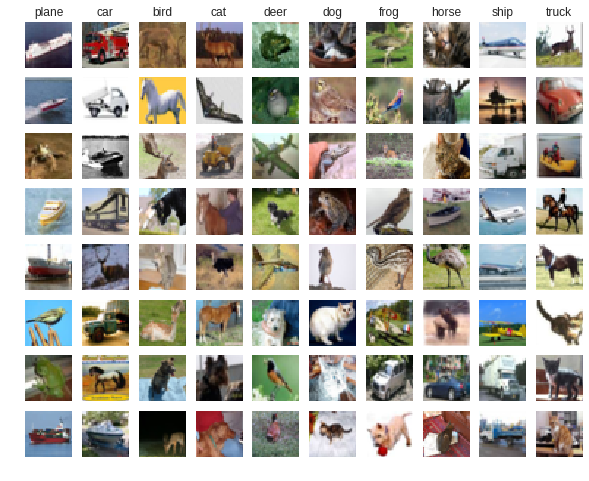

In [0]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [0]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0, dropout=1.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape
    
    # Compute the forward pass   
    s1 = np.dot(X, W1) + b1
    h1 = np.maximum(0, s1)  # ReLU
    dr = (np.random.rand(*h1.shape) < dropout) / dropout
    h1 *= dr # !dropout
    s2 = np.dot(h1, W2) + b2
    
    if y is None:
      return s2
    # Compute the loss
    
    s2 -= np.max(s2, axis=1, keepdims=True) # this not change any results, but improve numerical stability of computation 
    probs = np.exp(s2) / np.sum(np.exp(s2), axis=1, keepdims=True) # [N x K]
    probs_trueclass = probs[range(N), y]
    loss = np.sum(-np.log(probs_trueclass))/N 
    
    # regularization
    regularization = 0.5 * reg * (np.sum(W1*W1) + np.sum(W2*W2))
    loss = loss + regularization
    
    probs[range(N),y] -= 1
 
    
    #Back propagation
    grads = {}
    grads['W2'] = np.dot(h1.T, probs)/N + reg * W2
    grads['b2'] = np.sum(probs, axis = 0, keepdims=True)/N
    dhidden = np.dot(probs, W2.T)
    dhidden[h1 <= 0] = 0
    grads['W1'] = np.dot(X.T, dhidden)/N + reg * W1
    grads['b1'] = np.sum(dhidden, axis=0, keepdims=True)/N 

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False, dropout=1.0):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      rnd_index = np.random.choice(num_train, batch_size, replace=True)

      X_batch = X[rnd_index]
      y_batch = y[rnd_index]
      
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg, dropout=dropout)
      loss_history.append(loss)
      
      for param in grads:
        
        self.params[param] = self.params[param] - learning_rate * grads[param]

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']

    s1 = np.dot(X, W1) + b1
    h1 = np.maximum(0, s1) # ReLU
    s2 = np.dot(h1, W2) + b2

    y_pred = np.argmax(s2, axis=1)

    return y_pred




In [0]:
def plot_la(stats):

  # Plot the loss function and train / validation accuracies
  plt.subplot(2, 1, 1)
  plt.plot(stats['loss_history'])
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  plt.subplot(2, 1, 2)
  plt.plot(stats['train_acc_history'], label='train')
  plt.plot(stats['val_acc_history'], label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()
  plt.show()
  

1 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.399927345035 lr decay: 0.900301736175 reg 0.00234829648707 dropout: 0.702340460371
Time: 49.7330992222 --- Train acc:  0.6140252976190477 --- Val acc:  0.609


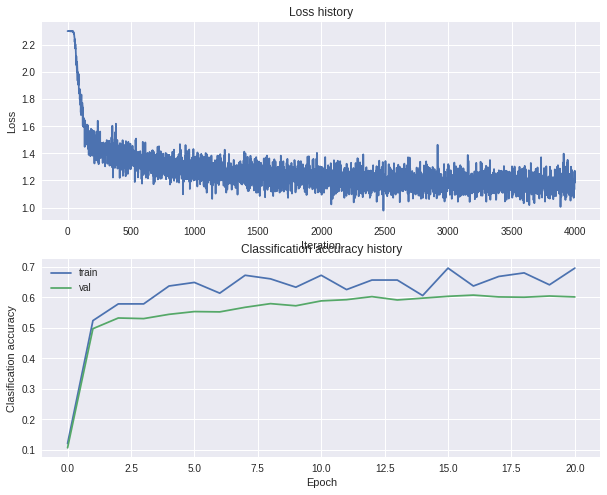

2 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.398570470854 lr decay: 0.926711194591 reg 0.00212097645554 dropout: 0.864588233412
Time: 50.3733510971 --- Train acc:  0.6555059523809523 --- Val acc:  0.612


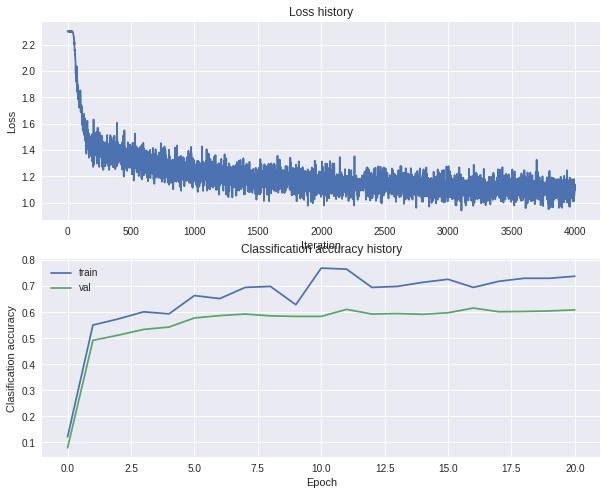

3 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.370673398882 lr decay: 0.915737359253 reg 0.00195412876032 dropout: 0.896015362544
Time: 50.3841819763 --- Train acc:  0.6393229166666666 --- Val acc:  0.607
4 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.40012130547 lr decay: 0.915057472654 reg 0.00188580365557 dropout: 0.736708771508
Time: 50.8127470016 --- Train acc:  0.6356026785714286 --- Val acc:  0.605
5 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.404579235901 lr decay: 0.928680244648 reg 0.00153295384907 dropout: 0.979806144701
Time: 48.9249119759 --- Train acc:  0.6800595238095238 --- Val acc:  0.593
6 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.385134617393 lr decay: 0.908476054831 reg 0.00159387728506 dropout: 0.835241149382
Time: 49.4396839142 --- Train acc:  0.6458333333333334 --- Val acc:  0.608
7 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.38637574408 lr deca

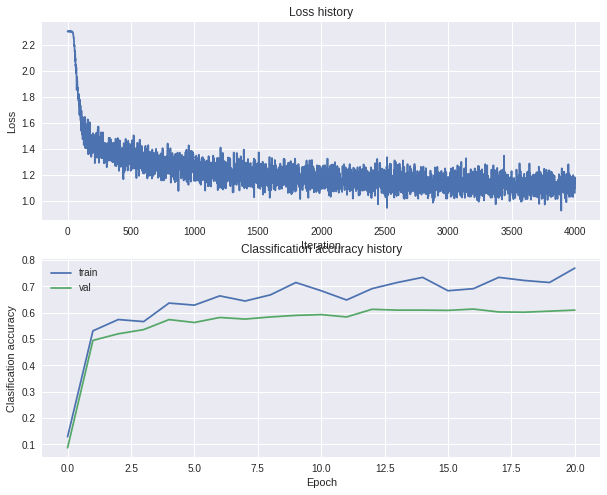

9 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.412479505125 lr decay: 0.91983659216 reg 0.0022355709552 dropout: 0.986624453059
Time: 48.2975330353 --- Train acc:  0.6595982142857143 --- Val acc:  0.613
10 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.414066780023 lr decay: 0.917808366575 reg 0.0015162116296 dropout: 0.994801835557
Time: 48.4315540791 --- Train acc:  0.6813616071428571 --- Val acc:  0.6
11 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.409993342892 lr decay: 0.931519927518 reg 0.00237919973498 dropout: 0.765714490768
Time: 49.4974310398 --- Train acc:  0.6532738095238095 --- Val acc:  0.61
12 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.408762940285 lr decay: 0.934100081145 reg 0.00233749315248 dropout: 0.782021433536
Time: 49.4297890663 --- Train acc:  0.6508556547619048 --- Val acc:  0.609
13 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.392558276337 lr deca

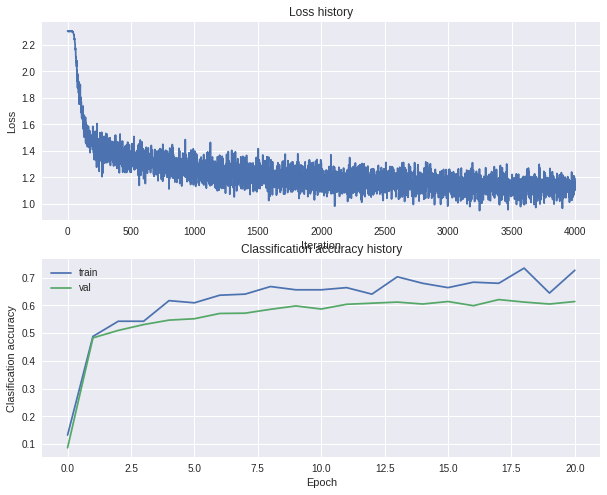

20 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.419381935526 lr decay: 0.92566672358 reg 0.0023183822817 dropout: 0.938197953015
Time: 99.0244760513 --- Train acc:  0.6694568452380952 --- Val acc:  0.609
21 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.389005154455 lr decay: 0.903793239833 reg 0.00232284550533 dropout: 0.884446645556
Time: 101.489332914 --- Train acc:  0.6263020833333334 --- Val acc:  0.62
22 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.386981295961 lr decay: 0.920896582378 reg 0.00150358111102 dropout: 0.903600950947
Time: 101.796277046 --- Train acc:  0.6651785714285714 --- Val acc:  0.616
23 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.373100733358 lr decay: 0.931109682876 reg 0.00221296400703 dropout: 0.902732053407
Time: 101.920066118 --- Train acc:  0.6437872023809523 --- Val acc:  0.605
24 N. Epochs: 4000 hidden size: 500 batch size: 256 
 learning rate: 0.419988178152 lr 

In [79]:

input_dim = X_train_feats.shape[1]
num_classes = 10
hidden_size = 500

count = 0
best_acc = -1
best_net = None # store the best model into this 
best_hp = []

for i in xrange(25):

  count +=1

  batches_sizes =  256
  learning_rates = np.random.uniform(.37, .42) # 10 ** np.random.uniform(-6, 2)
  regs = np.random.uniform(.0015, .0025) # 10 ** np.random.uniform(-6, 0.006)
  n_iters = 4000
  drpt = np.random.uniform(.70, 1) # np.random.uniform(0, 1)
  lr_decay = np.random.uniform(.90, .95)

  print(count, 'N. Epochs:', n_iters, 'hidden size:', 
        hidden_size, 'batch size:', batches_sizes, '\n learning rate:', 
        learning_rates, 'lr decay:', lr_decay, 'reg', regs, 'dropout:', drpt)
  net = TwoLayerNet(input_dim, hidden_size, num_classes)
  tic = time.time()
  stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
              num_iters=n_iters, 
              batch_size=batches_sizes,
              learning_rate=learning_rates, 
              learning_rate_decay=lr_decay,
              reg=regs, 
              verbose=False, 
              dropout=drpt)
  toc = time.time()
  time_train = toc-tic

  # Predict on the validation set
  val_acc = (net.predict(X_val_feats) == y_val).mean()
  print('Time:', time_train, 
        '--- Train acc: ', np.mean(stats['train_acc_history']),
        '--- Val acc: ', val_acc)
  if best_acc < val_acc:
    best_acc = val_acc
    best_net = net
    best_hp = [(learning_rates, lr_decay, regs, drpt)]

    # Plot the loss function and train / validation accuracies
    plot_la(stats)

In [80]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()

print(test_acc)

0.591
